The dataset contains the following columns:

1. **Loan_ID**: Unique identifier for each loan
2. **Gender**: Gender of the applicant
3. **Married**: Marital status of the applicant
4. **ApplicantIncome**: Income of the loan applicant
5. **LoanAmount**: Loan amount requested by the applicant.
6. **Loan_Status**: Status of the loan application (approved or not)




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler


In [2]:
df = pd.read_csv("/content/loan_data.csv")
df.head()

,Loan_ID,Gender,Married,ApplicantIncome,LoanAmount,Loan_Status
0,LP001002,Male,No,5849,NaN,Y
1,LP001003,Male,Yes,4583,128.0,N
2,LP001005,Male,Yes,3000,66.0,Y
3,LP001006,Male,Yes,2583,120.0,Y
4,LP001008,Male,No,6000,141.0,Y


## EDA

In [3]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'ApplicantIncome', 'LoanAmount',
       'Loan_Status'],
      dtype='object')

In [4]:
df.shape

(598, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Loan_ID          598 non-null    object 
 1   Gender           598 non-null    object 
 2   Married          598 non-null    object 
 3   ApplicantIncome  598 non-null    int64  
 4   LoanAmount       577 non-null    float64
 5   Loan_Status      598 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 28.2+ KB


In [6]:
df.describe()

,ApplicantIncome,LoanAmount
count,598.000000,577.000000
mean,5292.252508,144.968804
std,5807.265364,82.704182
min,150.000000,9.000000
25%,2877.500000,100.000000
50%,3806.000000,127.000000
75%,5746.000000,167.000000
max,81000.000000,650.000000


Loan Id is of no particular use to us so we'll be dropping it.

In [7]:
df.drop(columns='Loan_ID', inplace=True, axis=1)

In [8]:
df.columns

Index(['Gender', 'Married', 'ApplicantIncome', 'LoanAmount', 'Loan_Status'], dtype='object')

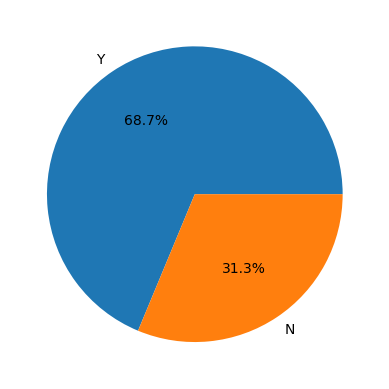

In [9]:
temp = df['Loan_Status'].value_counts()
plt.pie(temp.values, labels = temp.index, autopct = '%1.1f%%')
plt.show()

Here we can see the data set is imbalanced.

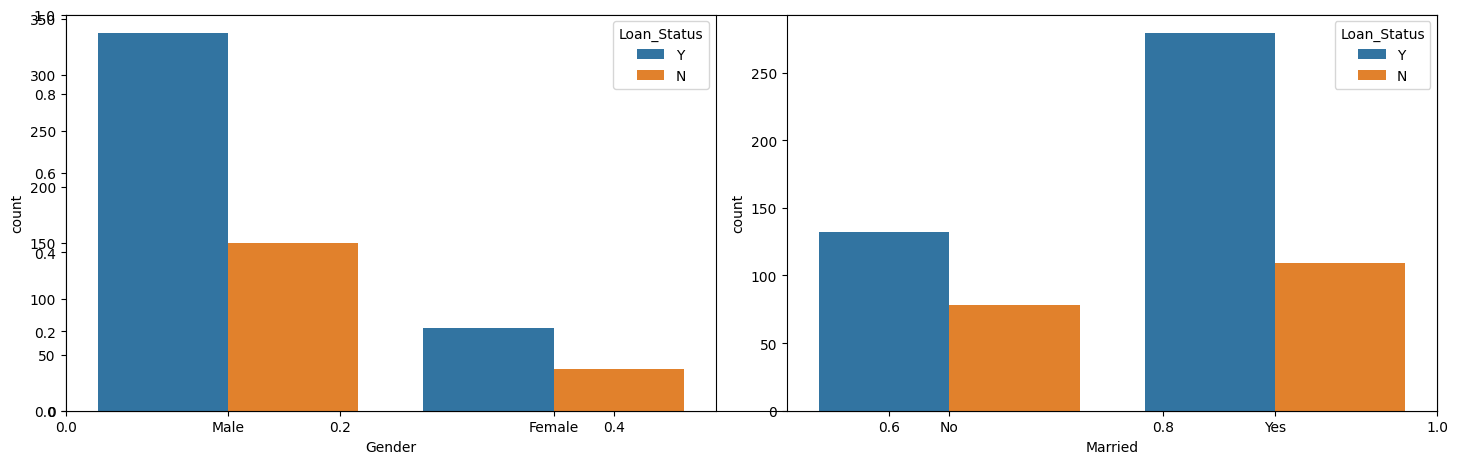

In [10]:
plt.subplots(figsize = (15, 5))
for i,col in enumerate(['Gender','Married']):
  plt.subplot(1,2,i+1)
  sns.countplot(data=df,x=col, hue='Loan_Status')

plt.tight_layout()
plt.show()

One of the main observation we can draw here is that the chances of getting loan approved for married people are quite low compare to those who are not married.

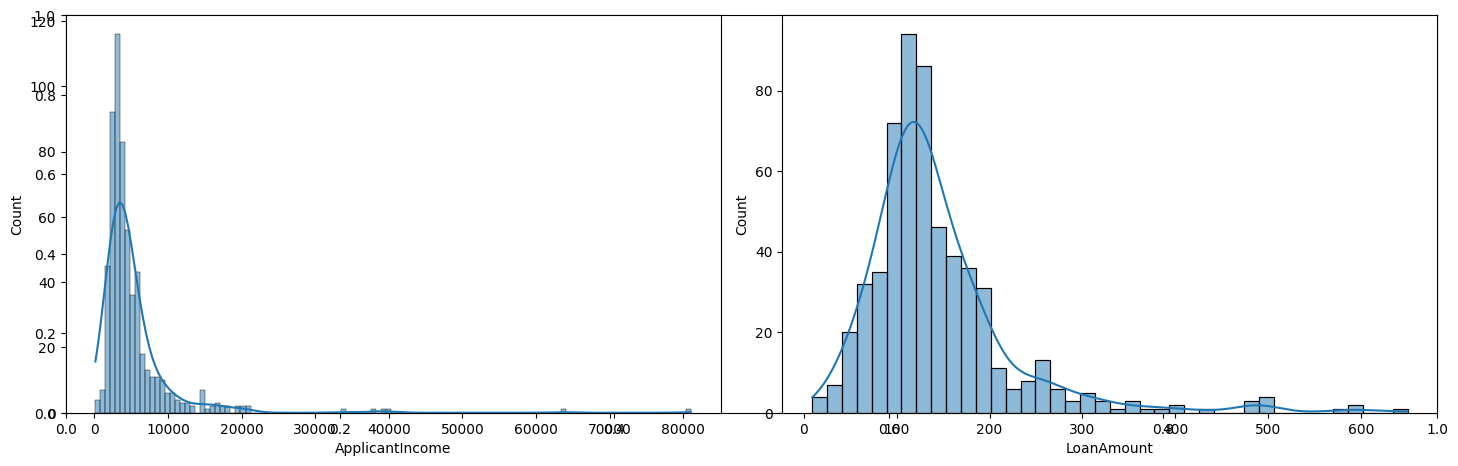

In [11]:
plt.subplots(figsize=(15,5))
for i, col in enumerate(['ApplicantIncome','LoanAmount']):
  plt.subplot(1, 2, i+1)
  sns.histplot(df[col], kde=True)
plt.tight_layout()
plt.show()

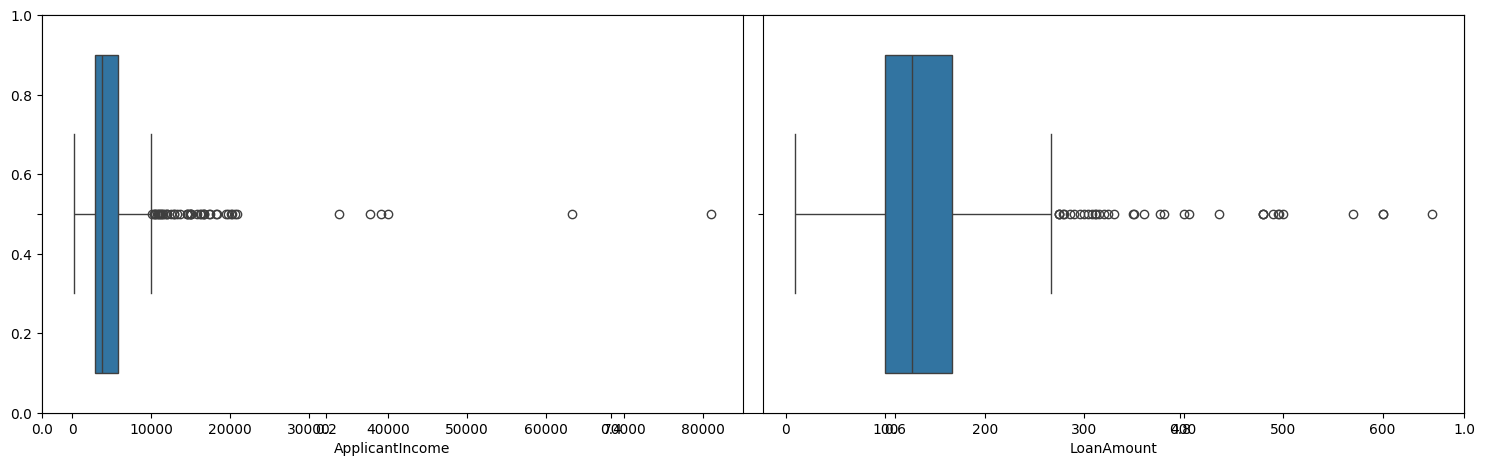

In [12]:
plt.subplots(figsize=(15,5))
for i, col in enumerate(['ApplicantIncome','LoanAmount']):
  plt.subplot(1, 2, i+1)
  sns.boxplot(x=df[col])
plt.tight_layout()
plt.show()

We can see there are a lot of outliers in the columns, so we need to remove them.

In [13]:
df = df[df['ApplicantIncome']<25000]
df = df[df['LoanAmount']<400000]

In [14]:
df.groupby('Gender').mean(numeric_only=True)['LoanAmount']

,LoanAmount
Gender,
Female,126.697248
Male,146.872294


In [15]:
df.groupby(['Married','Gender']).mean(numeric_only=True)['LoanAmount']

Married  Gender
No       Female    116.115385
         Male      135.959677
Yes      Female    153.322581
         Male      150.875740
Name: LoanAmount, dtype: float64

We can observe herr that the people who are married tend to ask for more loan amount than the one who are not married.

So from the previous barplot we can add that the married people tend to have lower chances of getting their loans approved.

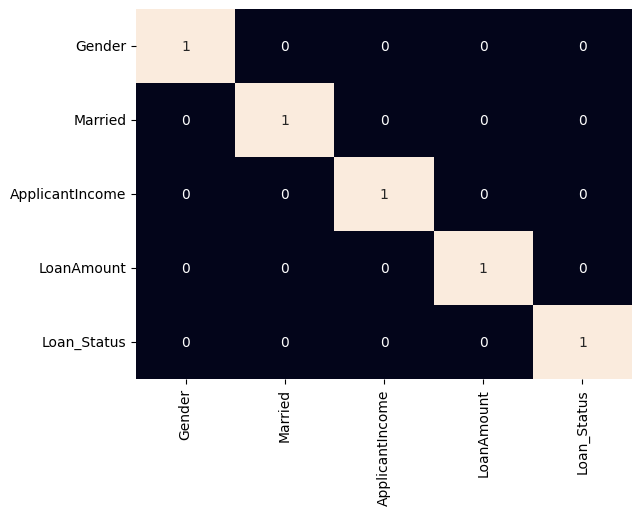

In [16]:
# Function to convert categorical data into numerical data.
def encode_labels(data):
  for col in data.columns:
    if data[col].dtype == 'object':
      le = LabelEncoder()
      data[col] = le.fit_transform(data[col])
  return data

df = encode_labels(df)

sns.heatmap(df.corr()>0.8, annot=True, cbar = False)
plt.show()

Since none of the columns are highly correlated we'll be using all those columns to train our model.

---



## Data Preprocessing.

Splitting the data for training and testing.

Reason to use RandomOverSampling : Since the data was highly imbalanced we will be adding repetitive rows of minority class.

In [17]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

x = df.iloc[:,:-1]    #Features
y = df.iloc[:,-1:]    #target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

ros = RandomOverSampler(sampling_strategy='minority', random_state = 0)
x, y = ros.fit_resample(x_train, y_train)

x_train.shape, x.shape

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


((456, 4), (636, 4))

Next step is to normalize the features for stable and fast training.

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)
x_test = scaler.transform(x_test)

Model Building and Model Evaluation.

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score as ras

model = SVC(kernel = 'rbf')
model.fit(x, y)

print("Training ROC AUC SCORE : ",ras(y, model.predict(x)))
print("Testing ROC AUC SCORE : ", ras(y_test, model.predict(x_test)))

Training ROC AUC SCORE :  0.5738993710691824
Testing ROC AUC SCORE :  0.5513361462728551


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


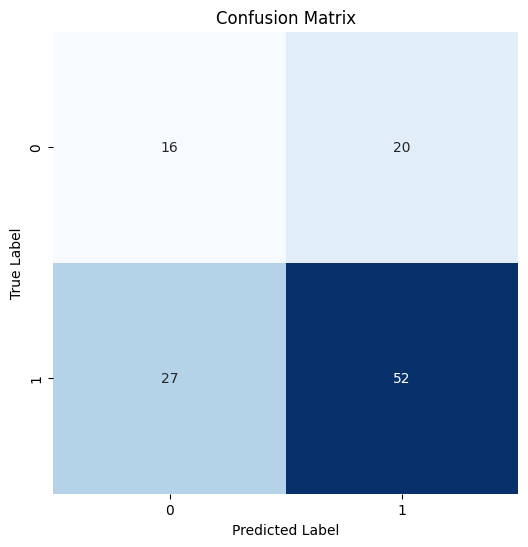

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, model.predict(x_test))
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel('True Label')
plt.show()

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.37      0.44      0.41        36
           1       0.72      0.66      0.69        79

    accuracy                           0.59       115
   macro avg       0.55      0.55      0.55       115
weighted avg       0.61      0.59      0.60       115



From above metrics we can conclude our model around 60% accurate hence it is not that good model. We can increse the accuracy using bagging or boosting or adaboost.

---

Thank you so much for going through my work till the end. Feel free to get in touch if you have any suggestions or doubts... :)